In [1]:
from dotenv import load_dotenv
import os
import json
from traopy_builder import builder as trab
from traopy_builder.builder import single_judge as trab_sj # type: ignore[reportMissingModuleSource]
import traopy_visualize as trav
load_dotenv('../../.env.dev')

True

In [2]:
builder = trab.Builder()

In [3]:
source = builder.add_runtime_text(
    name="source",
    label=trab_sj.label.submission_source(),
)
language_tag = builder.add_runtime_text(
    name="language_tag",
    label=trab_sj.label.language_tag()
)
time_limit = builder.add_runtime_text(
    name="time_limit",
    label=trab_sj.label.time_limit_ms()
)
memory_limit = builder.add_runtime_text(
    name="memory_limit",
    label=trab_sj.label.memory_limit_kib()
)

In [4]:
with open("scripts/build.py", "r") as f:
    build_script_content = f.read()
with open("scripts/run.py", "r") as f:
    run_script_content = f.read()
with open("scripts/summarize.py", "r") as f:
    summarize_script_content = f.read()

build_script = builder.add_script(
    name="build_script",
    content=build_script_content,
)
run_script = builder.add_script(
    name="run_script",
    content=run_script_content,
)
summarize_script = builder.add_script(
    name="summarize_script",
    content=summarize_script_content,
)

In [5]:
build_tempdir = builder.add_empty_directory(
    name="build_tempdir",
)
built = builder.add_execution(
    name=trab_sj.job_name.compile_phase(),
    script=build_script,
    dependencies=[
        trab.Dependency(
            outcome=source,
            envvar_name="BUILD_SOURCE_PATH"
        ),
        trab.Dependency(
            outcome=language_tag,
            envvar_name="LANGUAGE_TAG"
        ),
        trab.Dependency(
            outcome=build_tempdir,
            envvar_name="BUILD_TEMPDIR"
        )
    ],
    time_reserved_ms=40000,
)

In [6]:
testcases = [
    "case_1",
    "case_2",
    "case_3",
    "sample_1",
    "sample_2"
]
test_outcomes = []
for testcase in testcases:
    with open(f"testcases/{testcase}/input.txt", "r") as f:
        input_content = f.read()
    with open(f"testcases/{testcase}/output.txt", "r") as f:
        output_content = f.read()
    input_file = builder.add_static_text(
        name=trab_sj.job_name.test_input_file(testcase),
        content=input_content,
    )
    expected_file = builder.add_static_text(
        name=trab_sj.job_name.test_expected_file(testcase),
        content=output_content,
    )
    tempdir = builder.add_empty_directory(
        name=f"tempdir_{testcase}",
    )
    test_outcome = builder.add_execution(
        name=trab_sj.job_name.test_phase(testcase),
        script=run_script,
        dependencies=[
            trab.Dependency(
                outcome=language_tag,
                envvar_name="LANGUAGE_TAG"
            ),
            trab.Dependency(
                outcome=time_limit,
                envvar_name="TIME_LIMIT_MS"
            ),
            trab.Dependency(
                outcome=memory_limit,
                envvar_name="MEMORY_LIMIT_KIB"
            ),
            trab.Dependency(
                outcome=input_file,
                envvar_name="INPUT_FILE"
            ),
            trab.Dependency(
                outcome=expected_file,
                envvar_name="EXPECTED_FILE"
            ),
            trab.Dependency(
                outcome=tempdir,
                envvar_name="TEMP_DIR"
            ),
            trab.Dependency(
                outcome=built,
                envvar_name="BUILD_OUTPUT_PATH"
            ),
            trab.Dependency(
                outcome=source,
                envvar_name="BUILD_SOURCE_PATH"
            ),
        ],
        time_reserved_ms=3000,
    )
    test_outcomes.append(test_outcome)

In [7]:
testcase_count_int = len(testcases)
testcase_count = builder.add_static_text(
    name="testcase_count",
    content=str(testcase_count_int),
)
ac_point = builder.add_static_text(
    name="ac_point",
    content="100",
)
dependencies: list[trab.Dependency] = [
    trab.Dependency(
        outcome=testcase_count,
        envvar_name="TESTCASE_COUNT"
    ),
    trab.Dependency(
        outcome=ac_point,
        envvar_name="AC_POINT"
    ),
]
for i in range(testcase_count_int):
    dependencies.append(
        trab.Dependency(
            outcome=test_outcomes[i],
            envvar_name=f"OUTPUT_JSON_{i}"
        )
    )
summarize = builder.add_execution(
    name=trab_sj.job_name.summary_phase(),
    script=summarize_script,
    dependencies=dependencies,
    time_reserved_ms=2000,
)

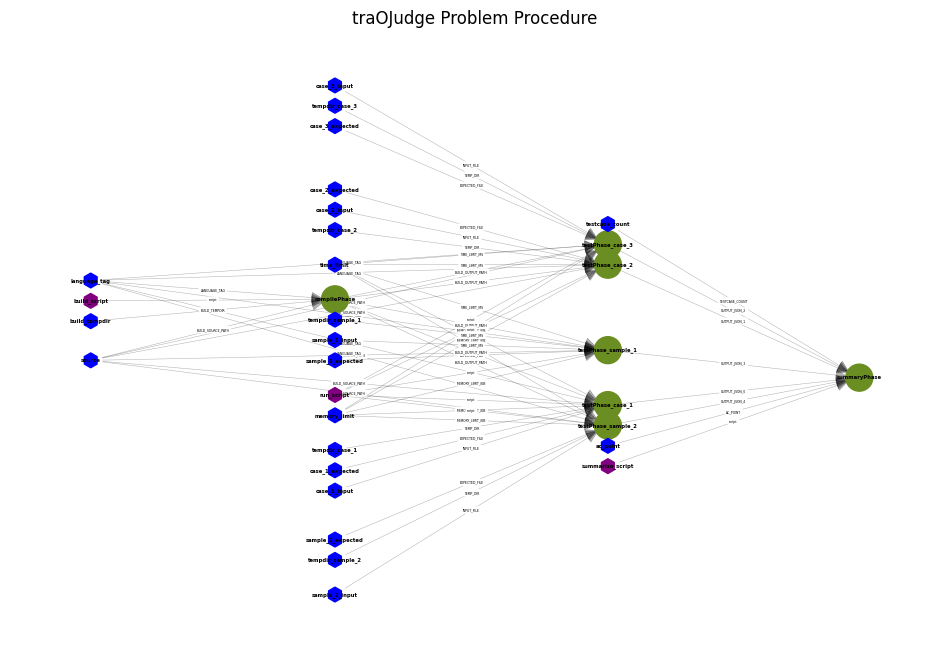

In [8]:
schema = builder.jsonify()
trav.visualize(schema)

In [ ]:
container_name = "exec-container:rqcgpwgksvp8xg23ci6cbsxpl0w1ivmw"
#container_name = "ubuntu:latest"
lang_name = "C++(clang)"

In [10]:
ac_cpp_source = '''
#include <iostream>
int main() {
    int a, b;
    std::cin >> a >> b;
    std::cout << a + b << std::endl;
    return 0;
}
'''
judge_resp = builder.run(
    {
        trab_sj.label.submission_source(): ac_cpp_source,
        trab_sj.label.language_tag(): lang_name,
        trab_sj.label.time_limit_ms(): "1000",
        trab_sj.label.memory_limit_kib(): "262144"
    },
    os.path.abspath("./tempdir"),
    "/trao/judge/temp",
    container_name
)
print(judge_resp)
trav.visualize(schema, judge_resp)

ValueError: Failed to run procedure: PyErr { type: <class 'ValueError'>, value: ValueError('Failed to judge: Internal error while executing a job: Docker container wait error'), traceback: None }

stdout: {"Displayable":{"status":"CE","time":5.0,"memory":20900.0,"score":0,"message":"","continue_status":"Stop"}}

stderr: /nix/store/b1wvkjx96i3s7wblz38ya0zr8i93zbc5-coreutils-9.5/bin/cp: missing file operand
Try '/nix/store/b1wvkjx96i3s7wblz38ya0zr8i93zbc5-coreutils-9.5/bin/cp --help' for more information.



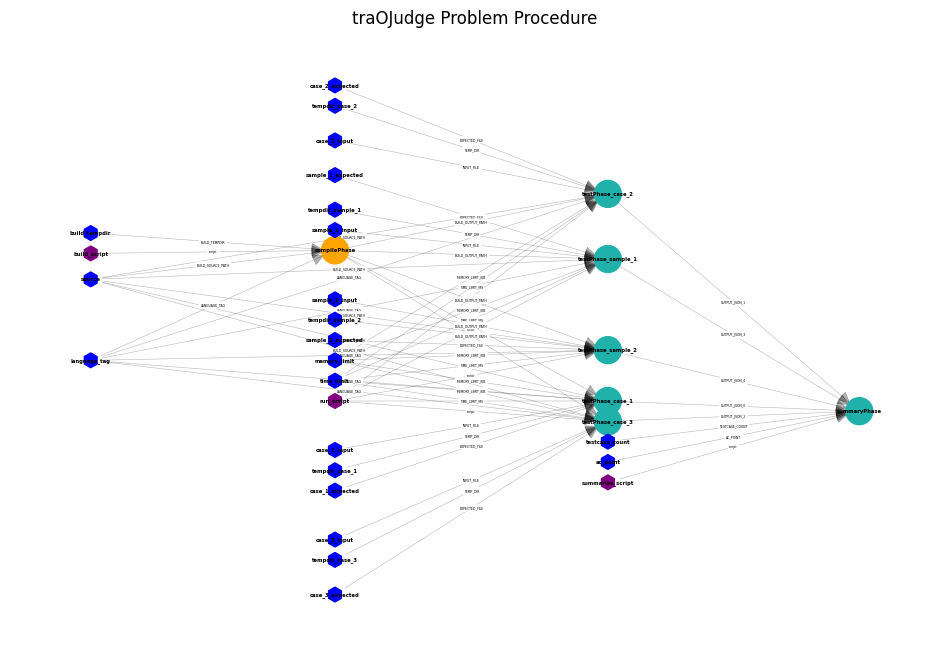

In [ ]:
wa_cpp_source = '''
#include <iostream>
int main() {
    int a, b;
    std::cin >> a >> b;
    if (a + b > 100) {
        std::cout << a + b << std::endl;
    }
    return 0;
}
'''
wa_judge_resp = builder.run(
    {
        trab_sj.label.submission_source(): wa_cpp_source,
        trab_sj.label.language_tag(): lang_name,
        trab_sj.label.time_limit_ms(): "1000",
        trab_sj.label.memory_limit_kib(): "262144"
    },
    os.path.abspath("./tempdir"),
    "/trao/judge/temp",
    container_name
)
trav.visualize(schema, wa_judge_resp)

stdout: {"Displayable":{"status":"CE","time":5.0,"memory":21204.0,"score":0,"message":"","continue_status":"Stop"}}

stderr: /nix/store/b1wvkjx96i3s7wblz38ya0zr8i93zbc5-coreutils-9.5/bin/cp: missing file operand
Try '/nix/store/b1wvkjx96i3s7wblz38ya0zr8i93zbc5-coreutils-9.5/bin/cp --help' for more information.



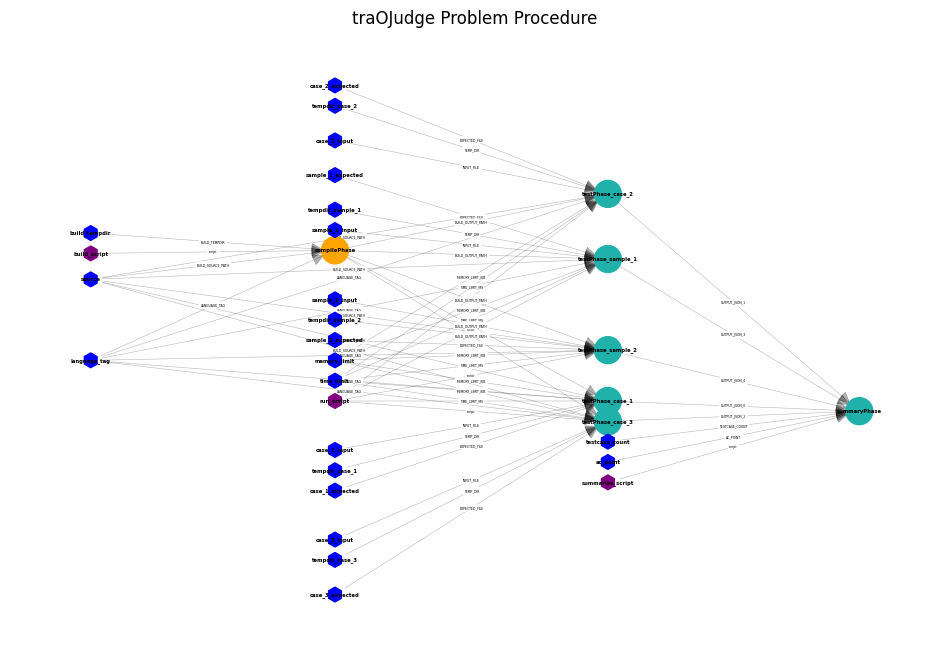

In [ ]:
tle_cpp_source = '''
#include <iostream>
int main() {
    int a, b;
    while (true);
    std::cin >> a >> b;
    return 0;
}
'''
tle_judge_resp = builder.run(
    {
        trab_sj.label.submission_source(): tle_cpp_source,
        trab_sj.label.language_tag(): lang_name,
        trab_sj.label.time_limit_ms(): "1000",
        trab_sj.label.memory_limit_kib(): "262144"
    },
    os.path.abspath("./tempdir"),
    "/trao/judge/temp",
    container_name
)
trav.visualize(schema, tle_judge_resp)

stdout: {"Displayable":{"status":"CE","time":5.0,"memory":21380.0,"score":0,"message":"","continue_status":"Stop"}}

stderr: /nix/store/b1wvkjx96i3s7wblz38ya0zr8i93zbc5-coreutils-9.5/bin/cp: missing file operand
Try '/nix/store/b1wvkjx96i3s7wblz38ya0zr8i93zbc5-coreutils-9.5/bin/cp --help' for more information.



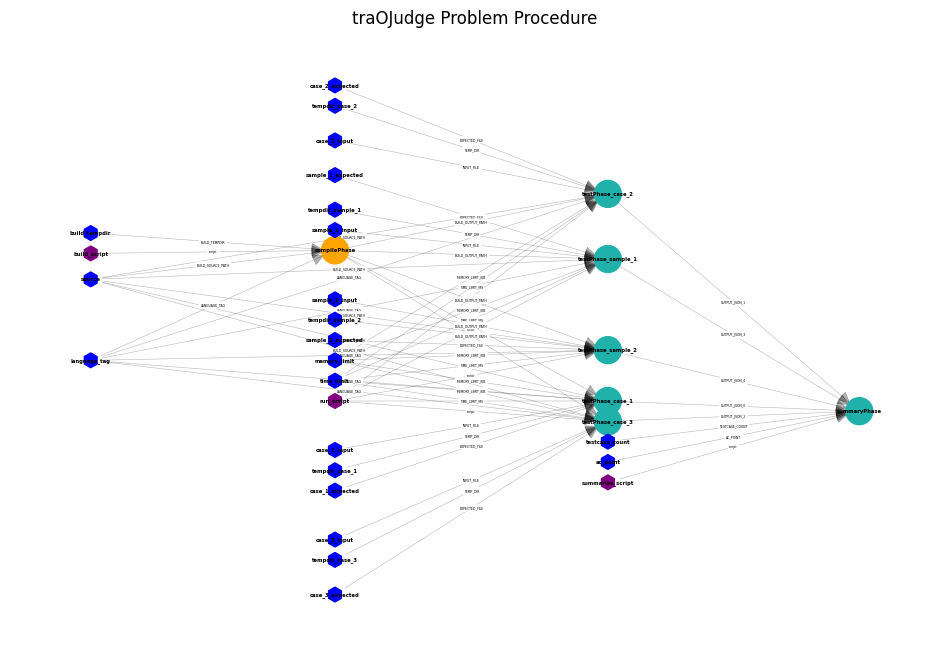

In [ ]:
ce_cpp_source = ""
ce_judge_resp = builder.run(
    {
        trab_sj.label.submission_source(): ce_cpp_source,
        trab_sj.label.language_tag(): lang_name,
        trab_sj.label.time_limit_ms(): "1000",
        trab_sj.label.memory_limit_kib(): "262144"
    },
    os.path.abspath("./tempdir"),
    "/trao/judge/temp",
    container_name
)
trav.visualize(schema, ce_judge_resp)

stdout: {"Displayable":{"status":"CE","time":4.0,"memory":21096.0,"score":0,"message":"","continue_status":"Stop"}}

stderr: /nix/store/b1wvkjx96i3s7wblz38ya0zr8i93zbc5-coreutils-9.5/bin/cp: missing file operand
Try '/nix/store/b1wvkjx96i3s7wblz38ya0zr8i93zbc5-coreutils-9.5/bin/cp --help' for more information.



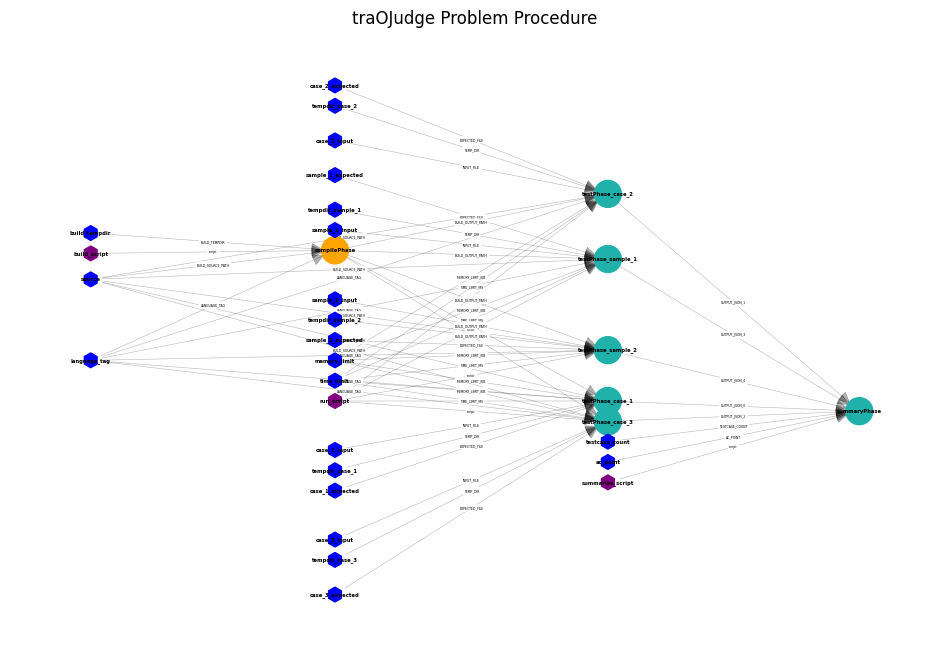

In [ ]:
read_ans_cpp_source = '''
#include <iostream>
#include <fstream>
#include <cstdlib>
#include <string>

int main() {
    char* expected_file_path = std::getenv("EXPECTED_FILE");
    if (expected_file_path) {
        std::ifstream expected_file(expected_file_path);
        if (expected_file.is_open()) {
            std::string line;
            while (std::getline(expected_file, line)) {
                std::cout << line << std::endl;
            }
            expected_file.close();
        }
    }
    return 0;
}

'''

read_ans_cpp_source = builder.run(
    {
        trab_sj.label.submission_source(): read_ans_cpp_source,
        trab_sj.label.language_tag(): lang_name,
        trab_sj.label.time_limit_ms(): "1000",
        trab_sj.label.memory_limit_kib(): "262144"
    },
    os.path.abspath("./tempdir"),
    "/trao/judge/temp",
    container_name
)
trav.visualize(schema, read_ans_cpp_source)